In [249]:
import numpy as np
import pandas as pd

col_names = ["start_time","end_time","open_price","closing_price","total_volume","bar_direction","cum_delta","bar_duration","volume_sec","high_wick_bid_ask","low_wick_bid_ask","bid_imb","ask_imb","price_sd","price_mean","net_delta_t3","net_delta_t2","net_delta_t1","log_return_p1"]

data = pd.read_csv("output.csv", skiprows=1, header=None, names=col_names)
data = data[["total_volume","bar_direction","cum_delta","bar_duration","volume_sec","bid_imb","ask_imb","price_sd","open_price","closing_price","price_mean","net_delta_t3","net_delta_t2","net_delta_t1","log_return_p1"]]

data['log_return_p1'] = data['log_return_p1'].shift(-1)
data = data.dropna()

data["log_return_p1"] = data["log_return_p1"].astype(float)
#data['log_bool'] = data['log_return_p1'].apply(lambda x: 'T' if float(x) > 0.2 else 'F')

def logic(row):
    if ((row["bar_direction"] == 1 and row["cum_delta"] < 0) or (row["bar_direction"] == -1 and row["cum_delta"] > 0)) and row["log_return_p1"] > 0.5:
        return 'T'
    else:
        return 'F'
    
data = data.assign(log_bool=data.apply(logic, axis=1))



len(data[data['log_bool'] == 'T'])

data[data['log_bool'] == 'T'].head(1000)
data[110:115]

,total_volume,bar_direction,cum_delta,bar_duration,volume_sec,bid_imb,ask_imb,price_sd,open_price,closing_price,price_mean,net_delta_t3,net_delta_t2,net_delta_t1,log_return_p1,log_bool
110,10183.63,1,1141.26,300.000,33.95,65,40,5.59,1234.98,1248.18,1245.16,-3029.35,-562.86,1141.26,0.14753,F
111,5415.51,-1,276.21,300.039,18.05,22,16,1.78,1248.19,1241.48,1244.75,-562.86,1141.26,276.21,0.90793,T
112,13352.68,-1,1110.64,299.958,44.52,28,47,3.42,1241.47,1231.84,1232.12,1141.26,276.21,1110.64,0.52592,T
113,12537.52,-1,-1361.93,299.894,41.81,45,61,5.92,1231.84,1220.44,1226.34,276.21,1110.64,-1361.93,0.75386,F
114,12206.18,-1,-1206.42,299.935,40.70,34,33,3.46,1220.44,1218.52,1216.25,1110.64,-1361.93,-1206.42,0.53973,F


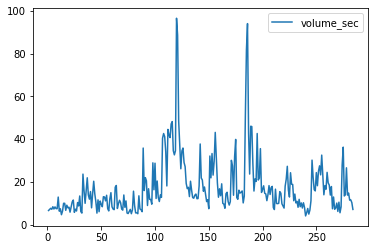

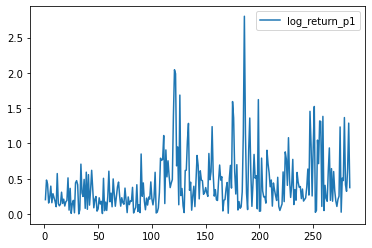

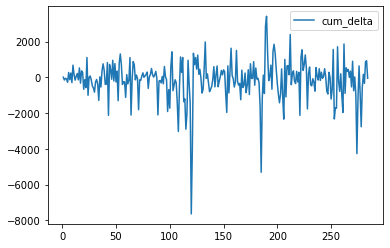

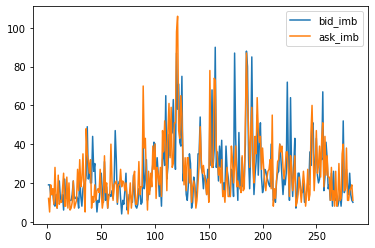

In [209]:
import matplotlib.pyplot as plt

data[["volume_sec"]].plot();
data[["log_return_p1"]].plot();
data[["cum_delta"]].plot();
data[["bid_imb","ask_imb"]].plot();

plt.show()

In [226]:
data.describe()
#data.corr()

,total_volume,bar_direction,cum_delta,bar_duration,volume_sec,bid_imb,ask_imb,price_sd,price_mean,net_delta_t3,net_delta_t2,net_delta_t1,log_return_p1
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,5197.473239,-0.126761,-154.263275,300.127173,17.321655,24.640845,25.602113,3.121901,1225.489437,-164.759401,-158.907711,-154.263275,0.427215
std,4022.786952,0.993684,1105.439034,0.494798,13.411915,16.244745,15.999783,1.904873,68.094157,1102.628838,1103.642847,1105.439034,0.400851
min,1211.410000,-1.000000,-7637.100000,298.392000,4.020000,4.000000,4.000000,0.670000,1080.110000,-7637.100000,-7637.100000,-7637.100000,0.000760
25%,2653.322500,-1.000000,-540.270000,299.976500,8.845000,14.000000,14.000000,1.727500,1173.135000,-546.412500,-540.270000,-540.270000,0.160410
50%,4112.960000,-1.000000,-63.150000,300.046500,13.695000,20.000000,21.500000,2.685000,1215.295000,-68.015000,-64.415000,-63.150000,0.307495
75%,6091.170000,1.000000,404.307500,300.247500,20.285000,30.000000,33.000000,3.837500,1296.942500,391.175000,397.335000,404.307500,0.572242
max,28968.420000,1.000000,3416.470000,303.725000,96.560000,90.000000,106.000000,11.250000,1334.440000,3416.470000,3416.470000,3416.470000,2.803000


In [240]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree


# Grab our X & Y Columns.
X_Cols = data[["total_volume","cum_delta","bar_duration","volume_sec","bid_imb","ask_imb","price_sd","net_delta_t3","net_delta_t2"]]
Y_Cols = data["log_bool"]

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)
# Make predictions
y_pred = rand_frst_clf.predict(X_test)
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

#y_pred = rand_frst_clf.predict([[540.16,1,79.14,59.786,9.03,4,1,1.21,1179.89,109.86,-1818.58,79.14]])


# Define the traget names
#target_names = ['log_bool']

# Build a classifcation report
#report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
#report_df = pd.DataFrame(report).transpose()
#report_df


Correct Prediction (%):  92.95774647887323


Feature: 0, Score: 0.09585
Feature: 1, Score: 0.10019
Feature: 2, Score: 0.08661
Feature: 3, Score: 0.10773
Feature: 4, Score: 0.08369
Feature: 5, Score: 0.09417
Feature: 6, Score: 0.09059
Feature: 7, Score: 0.12680
Feature: 8, Score: 0.08596
Feature: 9, Score: 0.12841


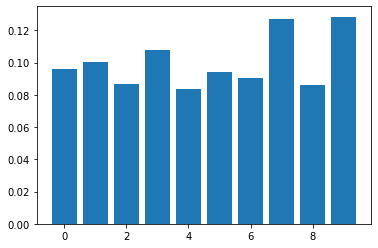

In [230]:
importance = rand_frst_clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()
